# CONTINUOUS PPO for extract data and training
https://github.com/CVxTz/RL/tree/main


tqdm==4.50.2
torch==1.6.0
gym==0.17.3
numpy==1.19.2
Pillow==8.0.1

In [ ]:
!pip install tqdm==4.50.2
!pip install torch==1.6.0
!pip install gym==0.17.3
!pip install numpy==1.19.2
!pip install Pillow==8.0.1

In [ ]:
!pip uninstall -y tqdm torch gym numpy Pillow

In [ ]:
!pip install torch==1.7.1

In [32]:
import numpy as np
import matplotlib.pyplot as plt #plotting library
from matplotlib import animation #animated visualizations library
from collections import namedtuple, deque
#nametuple creates tuple subclasses with name fields, access elements by names instead of index
#deque (double-ended queue) for adding and removing elements from both ends
from tqdm import tqdm
#add progress bars to Python code for easy monitoring progress of loops and tasks
# %matplotlib inline
import gym #environments for agents
from datetime import datetime #manipulating dates and times
import pandas as pd #work with structured data
import torch #Pytorch supports tensor computations and neural networks
import torch.nn as nn #Pytorch supports building neural networks
import torch.nn.functional as Function
#common functions in neural network operations
    # Activation functions (ReLU, sigmoid, tanh)
    # Loss functions (cross_entropy, mse_loss)
    #Utility functions for tensor manipulation (softmax, dropout, batch_norm, etc.)
import torch.optim as optim #optimization algorithms for training neural networks
import random #generate random numbers/selections
from collections import namedtuple, deque
import itertools
# provides various functions for creating iterators and combining them for complex interators
# includes cycle, chain, zip, etc.

## Model

In [33]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.distributions import Categorical

# Define device (CPU or GPU) for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define neural network architecture for policy
class PolicyNetwork(torch.nn.Module):
    def __init__(self, n, in_dim, seed):
        super(PolicyNetwork, self).__init__()
        self.seed = torch.manual_seed(seed) # Set the random seed
        # Define fully connected layers for the network
        self.fc1 = torch.nn.Linear(in_dim, 128)
        self.fc2 = torch.nn.Linear(128, 128)
        self.fc3 = torch.nn.Linear(128, 128)

        self.fc4 = torch.nn.Linear(128, n)
        # Define activation function (LeakyReLU)
        self.l_relu = torch.nn.LeakyReLU(0.1)
    
    # Define forward pass of the network
    def forward(self, x):

        x = self.l_relu(self.fc1(x))
        x = self.l_relu(self.fc2(x))
        x = self.l_relu(self.fc3(x))
        y = self.fc4(x)
        y = F.softmax(y, dim=-1) # Apply softmax to output

        return y
    
    # Method to sample an action based on current state
    def sample_action(self, state):
        # Check if the input state is a torch.Tensor, if not, convert it to one
        if not state is torch.Tensor:
            state = torch.from_numpy(state).float().to(device)
        
        # If the state is 1-dimensional, add a batch dimension
        if len(state.size()) == 1:
            state = state.unsqueeze(0)
        
        # Pass the state through the policy network to get the action probabilities
        y = self(state) #pass state input to policy network to obtain probabilities

        dist = Categorical(y) # Turn raw probabilities to probability distribution to sample

        action = dist.sample() #samples 1 action from the categorical distribution 

        log_probability = dist.log_prob(action) #calculate the log of the probability

        return action.item(), log_probability.item()
        #action.item() retreives sampled action as an integer
        #log_prob.item() retrieves log probability off sampled action ass a scalar float value
    
    # Method to select the best action based on current state
    def best_action(self, state):
        # Check if the input state is a torch.Tensor, if not, convert it to one
        if not state is torch.Tensor:
            state = torch.from_numpy(state).float().to(device)
        
        # If the state is 1-dimensional, add a batch dimension
        if len(state.size()) == 1:
            state = state.unsqueeze(0)
        
        # Pass the state through the policy network to get the action probabilities
        #squeeze is used to remove singleton dimensions
        y = self(state).squeeze()
        
        #Choose action with maximum probability
        action = torch.argmax(y)

        return action.item() #Convert argmax tensor to standard python integer
    
    # Method to evaluate actions based on current state
    def evaluate_actions(self, states, actions):
        y = self(states) #input a batch of states, and y output probabilities
                            #for each action at each state

        dist = Categorical(y) # Turn raw probabilities to probability distribution 

        entropy = dist.entropy() #calculate entropy of the distribution
                            #High entropy: greater uncertainty
                            #low entropy: more certainty

        log_probabilities = dist.log_prob(actions) #calculate the log of the probability

        return log_probabilities, entropy #returns the calculated log probabilities and entropy as a tuple 

# Define neural network architecture for value function
class ValueNetwork(torch.nn.Module):
    def __init__(self, in_dim, seed):
        super(ValueNetwork, self).__init__()
        self.seed = torch.manual_seed(seed) # Set the random seed
        # Define fully connected layers for the network
        self.fc1 = torch.nn.Linear(in_dim, 128)
        self.fc2 = torch.nn.Linear(128, 128)
        self.fc3 = torch.nn.Linear(128, 128)

        self.fc4 = torch.nn.Linear(128, 1)
        # Define activation function (LeakyReLU)
        self.l_relu = torch.nn.LeakyReLU(0.1)
    
    # Define forward pass of the network
    def forward(self, x):

        x = self.l_relu(self.fc1(x))
        x = self.l_relu(self.fc2(x))
        x = self.l_relu(self.fc3(x))

        y = self.fc4(x)

        return y.squeeze(1) # Squeeze the output to remove extra dimension
    
    
    # Method to estimate state value based on current state
    def state_value(self, state):

        if not state is torch.Tensor:
            state = torch.from_numpy(state).float().to(device)

        if len(state.size()) == 1:
            state = state.unsqueeze(0)

        y = self(state) #pass through the value network to get ouput state value V

        return y.item()

    
# Function to train the value network
def train_value_network(value_model, value_optimizer, data_loader, epochs=4):
    epochs_losses = [] # List to store losses for each epoch
    
    # Iterate over specified number of epochs
    for i in range(epochs):

        losses = []  # List to store losses for each batch

        # Iterate over batches in the data loader
        for observations, _, _, _, rewards_to_go in data_loader:
            observations = observations.float().to(device) # Convert observations to float tensor
            rewards_to_go = rewards_to_go.float().to(device) # Convert rewards to go to float tensor

            value_optimizer.zero_grad() # Zero the gradients

            values = value_model(observations) # Get predicted values from value network
            
            # Calculate mean squared error loss between predicted values and rewards to go
            loss = F.mse_loss(values, rewards_to_go)

            loss.backward() # Backpropagate gradients

            value_optimizer.step() # Update value network parameters

            losses.append(loss.item()) # Append loss for this batch

        mean_loss = np.mean(losses) # Calculate mean loss for this epoch

        epochs_losses.append(mean_loss) # Append mean loss to list of epoch losses

    return epochs_losses # Return list of losses for each epoch



# Function to calculate Advantage-Clipped (AC) loss
def ac_loss(new_log_probabilities, old_log_probabilities, advantages, epsilon_clip=0.2):
    #compute probability ratio by computing the exponential of log - log
    probability_ratios = torch.exp(new_log_probabilities - old_log_probabilities)
    
    #Clipping
    clipped_probabiliy_ratios = torch.clamp(
        probability_ratios, 1 - epsilon_clip, 1 + epsilon_clip
        #the clip works by taking input, min, max.
            #below min -> min
            #above max -> max
            #prevent large updates that leads to divergence and instability
    )
    #new_log_porb: log prob of actions predicted by the current policy network
    #old_log_prob:Log prob of actions from the previous policy network 
                                    # (used for comparison with PPO)
    #advantage: Advantage values calculated based on rewards to go and value estimation
    #epsilon_clip: hyperparameter used to clip the ratio of new and old probabilities
                    #to prevent large policy updates
    
    
    # Compute surrogate objectives
    
    surrogate_1 = probability_ratios * advantages #unclipped objective
    surrogate_2 = clipped_probabiliy_ratios * advantages #clipped objective
#     if torch.any(torch.ne(surrogate_1, surrogate_2)):
#         print("Unclipped objective: ", surrogate_1)
#         print(" ")
#         print("Clipped objective: ", surrogate_2)
#         print(" ")

#         print("Chosen objective: ", -torch.min(surrogate_1, surrogate_2))
#         print(" ")
    # Take element-wise minimum of surrogates and negate
    return -torch.min(surrogate_1, surrogate_2) #Choose the smaller one and take its negative value



# Function to train the policy network
def train_policy_network(
    policy_model, policy_optimizer, data_loader, epochs=4, clip=0.2
):
    epochs_losses = [] # List to store losses for each epoch

    c1 = 0.01 # Coefficient for entropy bonus
    
    # Iterate over specified number of epochs
    for i in range(epochs):

        losses = [] # List to store losses for each batch
        
        
        # Iterate over batches in the data loader
        for observations, actions, advantages, log_probabilities, _ in data_loader:
            observations = observations.float().to(device) # Convert observations to float tensor
            actions = actions.long().to(device) # Convert actions to long tensor
            advantages = advantages.float().to(device) # Convert advantages to float tensor
            old_log_probabilities = log_probabilities.float().to(device) # Convert old log probabilities to float tensor

            policy_optimizer.zero_grad() # Zero the gradients
            
            # Get new log probabilities and entropy from policy network
            new_log_probabilities, entropy = policy_model.evaluate_actions(
                observations, actions
            )
            
            # Calculate PPO loss function
            loss = ( #ac_loss mean - c1*entropy mean
                ac_loss(
                    new_log_probabilities,
                    old_log_probabilities,
                    advantages,
                    epsilon_clip=clip,
                ).mean()
                - c1 * entropy.mean() #Encourage exploration by adding a term to the 
                                #loss function that penalizes low entropy policies
                                    #Incentivizes policies to maintain a level of randomness 
            # By multiplying the mean entropy by c1 and subtracting it from the loss function, 
                # we effectively penalize low entropy policies during optimization.
                #increase c1 = lead to policies with higher entropy (more exploration)
                #decrease c1 = reduce regulization, allow policies to be more deterministic
            )

            loss.backward() # Backpropagate gradients

            policy_optimizer.step() # Update policy network parameters

            losses.append(loss.item()) # Append loss for this batch

        mean_loss = np.mean(losses) # Calculate mean loss for this epoch

        epochs_losses.append(mean_loss) # Append mean loss to list of epoch losses

    return epochs_losses # Return list of losses for each epoch

## Replay 

In [34]:
import numpy as np

from torch.utils.data import Dataset


def cumulative_sum(array, gamma=1.0):
    #going back and adding the discounted reward
        # store in cummulative array the estimated value V at each state
    curr = 0
    cumulative_array = []

    for a in array[::-1]:
        curr = a + gamma * curr
        cumulative_array.append(curr)

    return cumulative_array[::-1]
    

class Episode:
    def __init__(self, gamma=0.99, lambd=0.95):
        self.observations = []
        self.actions = []
        self.advantages = []
        self.rewards = []
        self.rewards_to_go = []
        self.values = []
        self.log_probabilities = []
        self.gamma = gamma
        self.lambd = lambd

    def append(
        #add data at that timestep
        self, observation, action, reward, value, log_probability, reward_scale=20
    ):
        self.observations.append(observation)
        self.actions.append(action)
        self.rewards.append(reward / reward_scale)
        self.values.append(value)
        self.log_probabilities.append(log_probability)

    def end_episode(self, last_value):
        rewards = np.array(self.rewards + [last_value])
        values = np.array(self.values + [last_value])

        deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1] #Errors between estimate
        
#         print("Rewards at S+1: ", rewards)
#         print(" ")
#         print("Value at S+1*gamma: ", values[1:])
#         print(" ")
#         print("Value at S: ", values[:-1])
#         print(" ")
#         print("TD errors after each state: ", deltas )
#         print(" ")
        self.advantages = cumulative_sum(deltas.tolist(), gamma=self.gamma * self.lambd)
#         print("Advantages: ", self.advantages)
#         print(" ")
        #advantages sum the errors at each step

        self.rewards_to_go = cumulative_sum(rewards.tolist(), gamma=self.gamma)[:-1]
#         print("Rewards to go = current reward + discounted future rewards: ", self.rewards_to_go)
#         print(" ")
        
        #rewards to go sum the rewards at each step


def normalize_list(array):
    array = np.array(array) #Input list is converted to numpy for efficient numerical operations
    #normalize using z-score normalization, add constant to avoid dividing by zero
    array = (array - np.mean(array)) / (np.std(array) + 1e-5)
    # convert back to list to ensure function return same format as input
    return array.tolist()


class History(Dataset):
    def __init__(self):
        self.episodes = []
        self.observations = []
        self.actions = []
        self.advantages = []
        self.rewards = []
        self.rewards_to_go = []
        self.log_probabilities = []

    def free_memory(self): #clear all data to free up memory
        del self.episodes[:] #delete all elements
        del self.observations[:]
        del self.actions[:]
        del self.advantages[:]
        del self.rewards[:]
        del self.rewards_to_go[:]
        del self.log_probabilities[:]

    def add_episode(self, episode): #append new episode to episodes list
        self.episodes.append(episode)

    def build_dataset(self):
        #aggregating data from individual episodes and constructing a unified dataset
        for episode in self.episodes: #append to the existing lists
            self.observations += episode.observations
            self.actions += episode.actions
            self.advantages += episode.advantages
            self.rewards += episode.rewards
            self.rewards_to_go += episode.rewards_to_go
            self.log_probabilities += episode.log_probabilities

        assert (
            len(
                {
                    len(self.observations),
                    len(self.actions),
                    len(self.advantages),
                    len(self.rewards),
                    len(self.rewards_to_go),
                    len(self.log_probabilities),
                }
            )
            == 1 #Assertion to ensure consistency in length so that everything coresponds
                                    #to its episode
        )
#         print("History: ")
#         print(" ")
#         print("Observations (States): ", self.observations)
#         print(" ")
#         print("Actions: ", self.actions)
#         print(" ")
#         print("Rewards: ", self.rewards)
#         print(" ")
#         print("Rewards to go: ", self.rewards_to_go)
#         print(" ")
#         print("log_probabilities: ", self.log_probabilities)
#         print(" ")
#         print("Advantages: ", self.advantages)
#         print(" ")

        self.advantages = normalize_list(self.advantages)
            #apply normalization to the advantage
#         print("Advantages after normalizing: ", self.advantages)
#         print(" ")

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx): #get item in the corresponding index
        return (
            self.observations[idx],
            self.actions[idx],
            self.advantages[idx],
            self.log_probabilities[idx],
            self.rewards_to_go[idx],
        )

## Main

In [35]:
from pathlib import Path

import gym
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from collections import namedtuple, deque
import csv
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

# from PPO.model import (
#     PolicyNetwork,
#     ValueNetwork,
#     device,
#     train_value_network,
#     train_policy_network,
# )
# from PPO.replay import Episode, History

def main(
    env_names=["MountainCar-v0"], #, "LunarLander-v2"
    seeds=[1], #, 37, 42
    reward_scale=20.0,
    clip=0.2,
    log_dir="../logs",
    learning_rate=0.001,
    state_scale=1.0,
):
    for env_name in env_names:
        print("ENVIRONMENT:-----------", env_name)
        env_rewards = []
        result = []
        for seed in seeds:
            print("Seed = ", seed)
            env_log_dir = Path(log_dir) / env_name / f"seed_{seed}"
            env_log_dir.mkdir(parents=True, exist_ok=True)
            writer = SummaryWriter(
                log_dir=str(env_log_dir),
                filename_suffix=env_name,
                comment=f"{env_name}_seed_{seed}",
            )

            env = gym.make(env_name)
            env.seed(seed)
            torch.manual_seed(seed)
            np.random.seed(seed)

            observation = env.reset()

            n_actions = env.action_space.n
            feature_dim = observation.size

            value_model = ValueNetwork(in_dim=feature_dim, seed = seed).to(device)
            value_optimizer = optim.Adam(value_model.parameters(), lr=learning_rate)

            policy_model = PolicyNetwork(n=n_actions, in_dim=feature_dim, seed = seed).to(device)
            policy_optimizer = optim.Adam(policy_model.parameters(), lr=learning_rate)

            n_epoch = 4

            max_episodes = 20
#             max_timesteps = 400
            
            
            max_timesteps = env.spec.max_episode_steps
            
            print(max_timesteps)

            batch_size = 32

            max_iterations = 200

            history = History()

            epoch_ite = 0
            episode_ite = 0
            
            
            
            
            
            
            iteration_aver = []
            for ite in tqdm(range(max_iterations)):
                
                
                if ite % 50 == 0:
                    torch.save(
                        policy_model.state_dict(),
                        env_log_dir / (f"Seed {seed}_{env_name}_{str(ite)}_policy.pth"),
                    )
                    torch.save(
                        value_model.state_dict(),
                        env_log_dir / (f"Seed {seed}_{env_name}_{str(ite)}_value.pth"),
                    )
                
                if ite == max_iterations-1: #Iterations run from 0 to max iterations - 1
                    torch.save(
                        policy_model.state_dict(),
                        env_log_dir / (f"Seed {seed}_{env_name}_{str(max_iterations)}_policy.pth"),
                    )
                    torch.save(
                        value_model.state_dict(),
                        env_log_dir / (f"Seed {seed}_{env_name}_{str(max_iterations)}_value.pth"),
                    )
                
                episode_score = []
                episode_aver = []
                for episode_i in range(max_episodes):
#                     print("Episode: ", episode_i)
                    observation = env.reset()
                    episode = Episode()
                    score = 0
                    
                    for timestep in range(max_timesteps):

                        action, log_probability = policy_model.sample_action(
                            observation / state_scale
                        )
                        value = value_model.state_value(observation / state_scale)

                        new_observation, reward, done, info = env.step(action)

                        episode.append(
                            observation=observation / state_scale,
                            action=action,
                            reward=reward,
                            value=value,
                            log_probability=log_probability,
                            reward_scale=reward_scale,
                        )

                        observation = new_observation
                        
                        score = score + reward #Extract score for data
                        
                        if done:
                            episode.end_episode(last_value=0)
                            break

                        if timestep == max_timesteps - 1:
                            value = value_model.state_value(observation / state_scale)
                            episode.end_episode(last_value=value)

                    episode_ite += 1
                    writer.add_scalar(
                        "Average Episode Reward",
                        reward_scale * np.sum(episode.rewards),
                        episode_ite,
                    )
                    writer.add_scalar(
                        "Average Probabilities",
                        np.exp(np.mean(episode.log_probabilities)),
                        episode_ite,
                    )
                    
                    
                    history.add_episode(episode)
                    episode_score.append(score) #Score là 1 số append vào đây ta có 400 số
                
                episode_aver.append(np.mean(episode_score)) # size 3
                
                history.build_dataset()
                
                data_loader = DataLoader(history, batch_size=batch_size, shuffle=True)
                
                policy_loss = train_policy_network(
                    policy_model, policy_optimizer, data_loader, epochs=n_epoch, clip=clip
                )

                value_loss = train_value_network(
                    value_model, value_optimizer, data_loader, epochs=n_epoch
                )

                for p_l, v_l in zip(policy_loss, value_loss):
                    epoch_ite += 1
                    writer.add_scalar("Policy Loss", p_l, epoch_ite)
                    writer.add_scalar("Value Loss", v_l, epoch_ite)
                
                if ite == 0 or ite == 1 or ite == 198 or ite == 199:
                    print("Iteration number: ", ite + 1)
                    print("Policy Loss: ", policy_loss)
                    print("Value Loss: ", value_loss)
                
                history.free_memory()
            
                iteration_aver.append(np.mean(episode_aver)) #SIze 10
#               print(iteration_aver)
            result.append(iteration_aver)
            print(result)
        print("----------------End Algorithm--------------------")
        
        fig = plt.figure()
        
        reward_name = 'plots/PPO_' + env_name + '_result' + str(datetime.now().strftime("%Y%m%d%H%M%S"))
        df = pd.DataFrame({str(seeds[0]): result[0], str(seeds[1]): result[1], str(seeds[2]): result[2]})  # Use seed as column labels
        df.to_csv(reward_name + '.csv')
        print("------------------------End Environment-------------------")

        plt.xlabel("Episode")
        plt.ylabel("Reward")

        # Plot rewards for each seed
        for seed in seeds:
            plt.plot(df[str(seed)], label='Seed ' + str(seed))

        plt.title('Learning Curve ' + env_name)

        # Insert the legends in the plot
        fig.legend(loc='lower right')
        fig.savefig(reward_name + '.png', dpi=100)
                
                
if __name__ == "__main__":
    main(
        env_names=["MountainCar-v0"], #"LunarLander-v2", 
        seeds=[1], #, 37, 42
        reward_scale=20.0,
        clip=0.2,
        learning_rate=0.001,
        state_scale=1.0,
        log_dir="logs"
    )



  0%|                                                                                                          | 0/200 [00:00<?, ?it/s]

ENVIRONMENT:----------- MountainCar-v0
Seed =  1
200


  0%|▍                                                                                                 | 1/200 [00:03<11:38,  3.51s/it]

Iteration number:  1
Policy Loss:  [-0.009277965746819973, -0.012451727181673049, -0.010723970554769039, -0.011612344779074192]
Value Loss:  [2.0410576648712158, 1.363069932460785, 1.3744650764465332, 1.372262848854065]


  1%|▉                                                                                                 | 2/200 [00:07<11:36,  3.52s/it]

Iteration number:  2
Policy Loss:  [-0.009521867744624615, -0.01004841510206461, -0.009838709771633149, -0.011311334647238255]
Value Loss:  [1.4151550402641297, 1.3905174641609193, 1.3797111320495605, 1.3987937331199647]


100%|███████████████████████████████████████████████████████████████████████████████████████████████▌| 199/200 [08:42<00:02,  2.13s/it]

Iteration number:  199
Policy Loss:  [0.01109296883367104, 0.007951779356417693, -0.001960366766593636, 0.010734589202712252]
Value Loss:  [0.014599408742282795, 0.0021009187075334973, 0.0016440470744409177, 0.0013814981614577596]


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [08:44<00:00,  2.62s/it]

Iteration number:  200
Policy Loss:  [0.00160806170529931, 0.0030309689372140717, 0.0006991126980497747, -0.0016142542345302278]
Value Loss:  [0.016933700647266386, 0.015054973775190056, 0.01514229028314156, 0.014259428439177818]
[[-200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -198.9, -191.8, -185.4, -173.65, -157.3, -151.95, -148.8, -143.85, -136.55, -124.85, -123.05, -115.55, -125.9, -143.05, -146.8, -140.5, -147.6, -141.75, -190.6, -147.75, -142.85, -108.15, -109.3, -110.35, -111.3, -109.95, -111.6, -113.0, -121.05, -136.9, -115.25, -116.9, -116.25, -118.75, -115.75, -111.9, -105.85, -107.8, -109.2, -109.7, -103.75, -99.45, -99.9, -104.3, -105.6, -104.9, -103.95, -106.7, -96.7, -105.35, -103.7, -150.3, -138.55, -139.6, -131.4, -139.6, -187.25, -191.6, -191.9, -191.65, -200.0, -200.0, -200.0, -200.0, -200.0, -195.8, -200.0, -174.6, -139.7, -124.9, -144.45, -133.15, -111.4

IndexError: list index out of range

<Figure size 640x480 with 0 Axes>

## Render

In [24]:
import gym
import torch
from PIL import Image
from tqdm import tqdm
import random
import imageio
import cv2
import numpy as np


# from PPO.model import (
#     PolicyNetwork,
#     ValueNetwork,
#     device,
# )


def write_on_image(img, reward):

    cv2.putText(
        img,
        f"Sum Reward: {int(reward)}",
        (0, img.shape[0] - 20),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 0, 0),
        2,
    )


if __name__ == "__main__":
#     import argparse

#     parser = argparse.ArgumentParser()

#     parser.add_argument("--policy_path")
#     parser.add_argument("--env_name")
#     parser.add_argument("--n_episodes", type=int, default=5)
#     parser.add_argument("--max_timesteps", type=int, default=400)

#     parser.add_argument("--out_gif")

    state_scale = 1.0

#     args = parser.parse_args()

    policy_path = "logs/MountainCar-v0/seed_37/Seed 37_MountainCar-v0_200_policy.pth"
    env_name = "MountainCar-v0" #  "LunarLander-v2" 

    n_episodes = 10
    

    out_gif = "logs/mountaincar_seed37.gif"

    env = gym.make(env_name)
    max_timesteps = env.spec.max_episode_steps
    observation = env.reset()
    n_actions = env.action_space.n
    feature_dim = observation.size

    policy_model = PolicyNetwork(in_dim=feature_dim, n=n_actions, seed = 37).to(device)

    policy_model.load_state_dict(torch.load(policy_path))

    frames = []
    
    for _ in tqdm(range(n_episodes)):
        observation = env.reset()
        sum_reward = 0
        for timestep in range(max_timesteps):

            frames.append(np.ascontiguousarray(env.render(mode="rgb_array")))

            write_on_image(frames[-1], sum_reward)

            action = policy_model.best_action(observation / state_scale)

            new_observation, reward, done, info = env.step(action)
            sum_reward += reward

            if done:
                for a in range(10):
                    frames.append(np.ascontiguousarray(env.render(mode="rgb_array")))
                    write_on_image(frames[-1], sum_reward)
                break

            observation = new_observation

    imageio.mimsave(out_gif, frames, fps=60)

100%|████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.86s/it]


## Shaded plot

Standard deviation:  0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
         ...    
195     4.881171
196     8.875293
197     4.122802
198    11.163781
199    28.853610
Length: 200, dtype: float64
Mean:  0     -200.000000
1     -200.000000
2     -200.000000
3     -200.000000
4     -200.000000
          ...    
195   -104.816667
196   -108.016667
197   -103.350000
198   -113.450000
199   -128.233333
Length: 200, dtype: float64


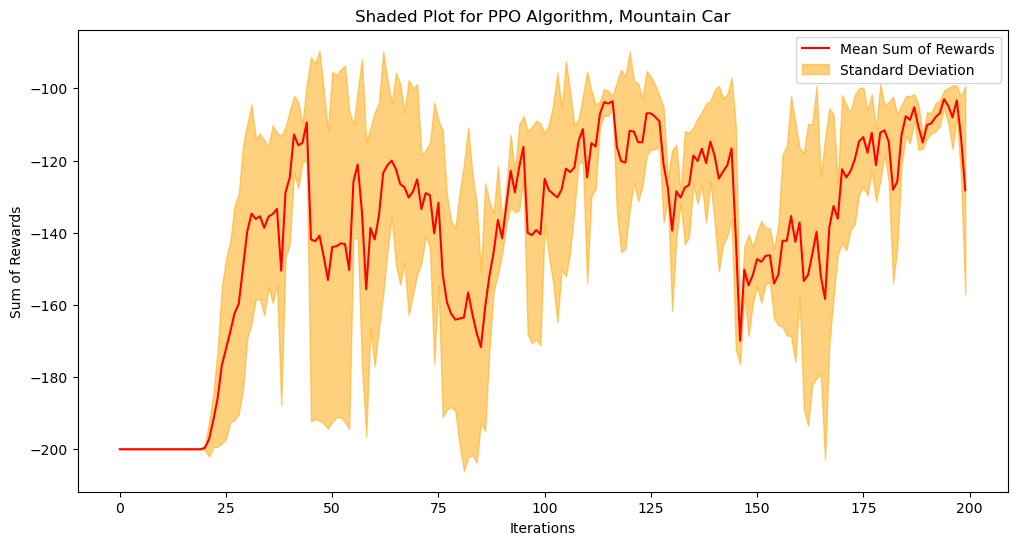

In [19]:
# Step 1: Read Data from CSV
df = pd.read_csv('plots/PPO_MountainCar-v0_result20240430181959.csv')

# Step 2: Remove the first row (Episodes, Run 1, Run 2, Run 3) to keep only the rewards data
# df = df.drop(0)

# Step 3: Convert the remaining DataFrame to numeric values
df = df.apply(pd.to_numeric)

# Step 4: Select only the three late columns (Run 1, Run 2, Run 3)
later_columns = df.iloc[:, 1:4]

# Step 5: Calculate Mean and Standard Deviation for the three later columns
mean_values = later_columns.mean(axis=1)
std_values = later_columns.std(axis=1)
print("Standard deviation: ", std_values)
print("Mean: ", mean_values)

# Step 6: Plot the Data
plt.figure(figsize=(12, 6))
plt.plot(mean_values, label='Mean Sum of Rewards', color = "red")
plt.fill_between(mean_values.index, mean_values - std_values, mean_values + std_values, alpha=0.5, label='Standard Deviation', color = "orange")
plt.xlabel('Iterations')
plt.ylabel('Sum of Rewards')
plt.title('Shaded Plot for PPO Algorithm, Mountain Car')
plt.savefig('plots/shaded_plot_PPO_MountainCar.png')
plt.legend()
plt.show()